In [326]:
%matplotlib inline
import numpy as np
import quantstats as qs
import pandas as pd
import yfinance as _yf
from pandas.tseries.offsets import MonthEnd

# Override function to use adjusted close, not Close
# https://github.com/ranaroussi/quantstats/blob/main/quantstats/utils.py#L233
def download_returns(ticker, period="max", proxy=None):
    params = {
        "tickers": ticker,
        "proxy": proxy,
    }
    if isinstance(period, pd.DatetimeIndex):
        params["start"] = period[0]
    else:
        params["period"] = period

    returns = _yf.download(**params)["Adj Close"].pct_change()
    return returns 

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
# ^IRX: Risk Free Rate (daily or annualized?) (based on 3-Month US Treasury Bills Rates): https://gist.github.com/ranaroussi/72d0e92bbe31d1514baccf00175049e4
stocks = [(
    # qs.utils.download_returns(t)
    download_returns(t)
    .reset_index()
    .assign(returns=lambda df: 1+df['Adj Close'])
    .drop(columns=['Adj Close'])
    .set_index(['Date'])
    .resample('ME')
    .prod()
    .assign(returns=lambda df: df['returns']-1)
    .reset_index()
    .assign(id=t)
    ) for t in ['SPY', 'SSO']]
stocks += [
    (
        (_yf.download("^IRX")["Adj Close"]/100)
        .reset_index()
        .assign(returns=lambda df: (1+df['Adj Close']) ** (1/252))
        .drop(columns=['Adj Close'])
        .set_index(['Date'])
        .resample('ME')
        .apply(lambda df: df['returns'].prod() - 1)
        .reset_index()
        .rename(columns={0: 'returns'})
        .assign(id='IRX')
    )
]
# stock.name = 'returns'
# stock2 = qs.utils.download_returns('BIL')
# stock2.name = 'returns'
stocks[1].tail(3)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Date   returns   id
212 2024-02-29  0.098965  SSO
213 2024-03-31  0.060207  SSO
214 2024-04-30 -0.108488  SSO

In [327]:
# data_filename_socgen = "lc_investing/data/socgen_trend_index_returns.xlsx"
data_filename_socgen = "c:\\Users\\Emile\\Documents\\lifecycle_investing\\lc_investing\\data\\socgen_trend_index_returns.xlsx"
trend_socgen = (
    pd.read_excel(data_filename_socgen)
    .drop(columns=['index level'])
    .rename(columns={'SG Trend Index': 'returns'})
    .assign(Date=lambda df: df['Date'] - MonthEnd(1))
    .assign(id='SG')
    # .set_index('Date')
)
data = (
    pd.concat(stocks+[trend_socgen], axis=0)
    .pivot(index='Date', columns='id', values='returns')
    .assign(IRX=lambda df: df['IRX']+ (0.0050/12))  # add 50 basis points to borrowing rate due to this blog post: https://www.returnstacked.com/return-stacking-and-the-cost-of-leverage/
    .assign(stocks_trend_m100_100_100=lambda df: (df[['IRX', 'SG', 'SPY']]*np.array([-1,1,1])).sum(axis=1))
    # .assign(stocks_trend_0_100_100=lambda df: (df[['IRX', 'SG', 'SPY']]*np.array([0,1,1])).sum(axis=1)) # zero borrowing cost
    .assign(stocks_trend_m100_0_200=lambda df: (df[['IRX', 'SG', 'SPY']]*np.array([-1,0,2])).sum(axis=1))
)
data1 = (
    data
    .drop(columns=['SPY', 'IRX'])
    .dropna()
)
print(data.tail(2))
data1.tail(3)

id               IRX        SG       SPY       SSO  stocks_trend_m100_100_100  \
Date                                                                            
2024-03-31  0.004469  0.040084  0.032702  0.060207                   0.068317   
2024-04-30  0.003454       NaN -0.053358 -0.108488                  -0.056812   

id          stocks_trend_m100_0_200  
Date                                 
2024-03-31                 0.060935  
2024-04-30                -0.110170  


id                SG       SSO  stocks_trend_m100_100_100  \
Date                                                        
2024-01-31  0.018186  0.024896                   0.029454   
2024-02-29  0.064375  0.098965                   0.112094   
2024-03-31  0.040084  0.060207                   0.068317   

id          stocks_trend_m100_0_200  
Date                                 
2024-01-31                 0.027195  
2024-02-29                 0.099906  
2024-03-31                 0.060935

In [328]:
qs.reports.html(data1, benchmark="SPY")

[*********************100%%**********************]  1 of 1 completed
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scal

[*********************100%%**********************]  1 of 1 completed


c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  r

                           Benchmark    SG          SSO         stocks_trend_m100_100_100    stocks_trend_m100_0_200
-------------------------  -----------  ----------  ----------  ---------------------------  -------------------------
Start Period               2006-07-31   2006-07-31  2006-07-31  2006-07-31                   2006-07-31
End Period                 2024-03-31   2024-03-31  2024-03-31  2024-03-31                   2024-03-31
Risk-Free Rate             0.0%         0.0%        0.0%        0.0%                         0.0%
Time in Market             100.0%       100.0%      100.0%      100.0%                       100.0%

Cumulative Return          310.25%      156.38%     915.74%     971.00%                      1,454.45%
CAGR﹪                     5.67%        3.75%       9.48%       9.7%                         11.31%

Sharpe                     2.58         2.36        2.65        3.56                         3.02
Prob. Sharpe Ratio         98.72%       98.52%      98.9

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2015-03-31  2018-12-31  2021-02-28  2162    -20.687998        -20.055405
2  2011-04-30  2014-02-28  2014-09-30  1250    -15.164284        -14.954886
3  2022-10-31  2023-02-28  2024-02-29   487    -13.100868        -10.600693
4  2007-06-30  2007-07-31  2007-11-30   154    -11.464072         -6.036908
5  2009-02-28  2009-12-31  2010-07-31   519     -8.655701         -7.859278

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2007-06-30  2009-02-28  2013-09-30  2285    -81.344141        -78.627501
2  2022-01-31  2022-09-30  2024-01-31   731    -45.693210        -38.984339
3  2020-01-31  2020-03-31  2020-07-31   183    -40.910703        -26.030383
4  2018-10-31  2018-12-31  2019-06-30   243    -27.007993        -15.526826
5  2015-06-30  2015-09-30  2016-06-30   367    -17.364385        -16.328974

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2008-06-30  2009-02-28  2010-11-30   884    -45.522490        -42.356155
2  2011-04-30  2011-09-30  2012-03-31   337    -23.141337        -14.883735
3  2018-01-31  2018-12-31  2019-05-31   486    -21.777476        -15.075289
4  2022-04-30  2023-02-28  2024-01-31   642    -19.600929        -18.607868
5  2019-08-31  2020-03-31  2020-06-30   305    -18.863895         -9.839649

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2007-11-30  2009-02-28  2013-02-28  1918    -78.607820        -75.056075
2  2022-01-31  2022-09-30  2024-01-31   731    -45.328374        -38.180524
3  2020-01-31  2020-03-31  2020-07-31   183    -37.177298        -21.254259
4  2018-10-31  2018-12-31  2019-03-31   152    -26.927423        -15.398730
5  2015-08-31  2015-09-30  2016-04-30   244    -16.753013        -15.081816

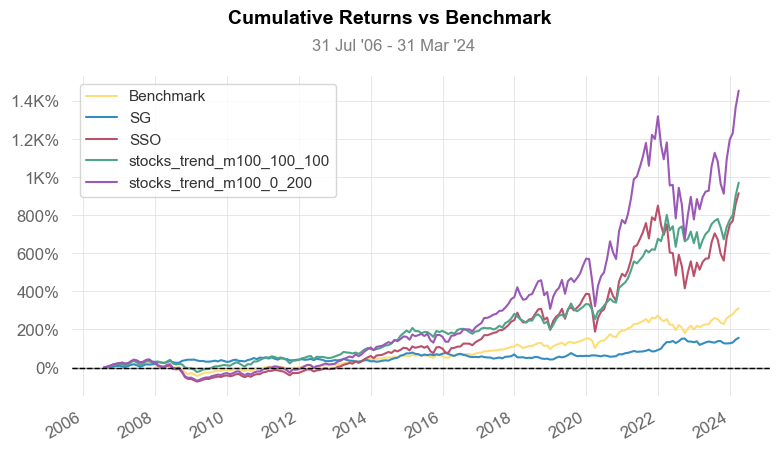

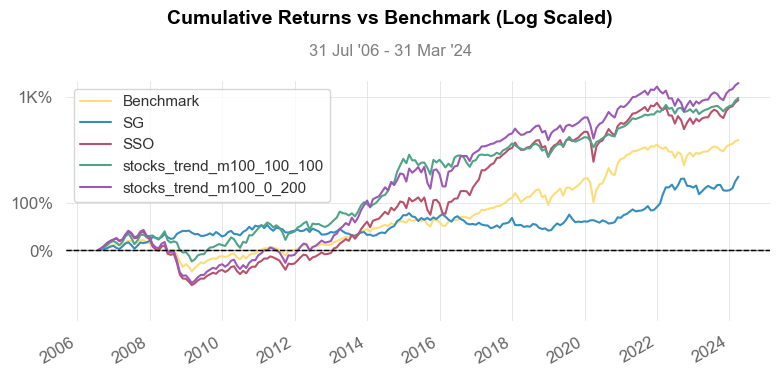

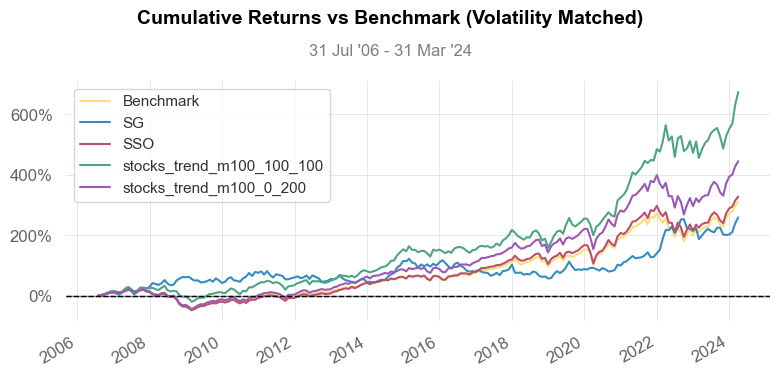

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\wrappers.py:555: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\wrappers.py:557: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


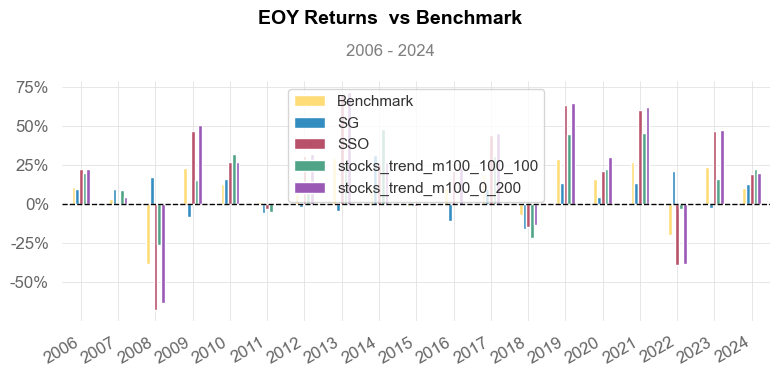

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:433: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:435: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


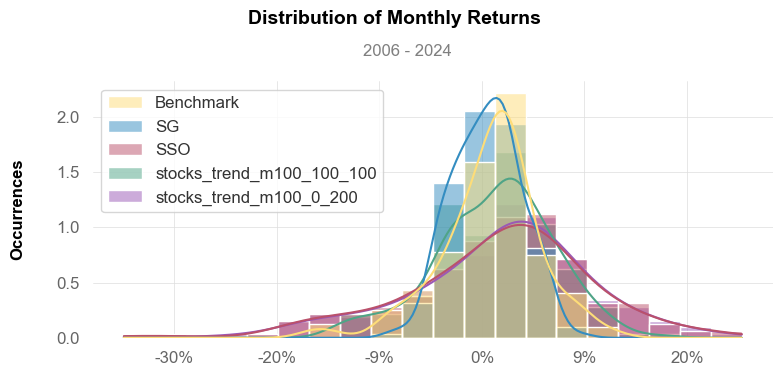

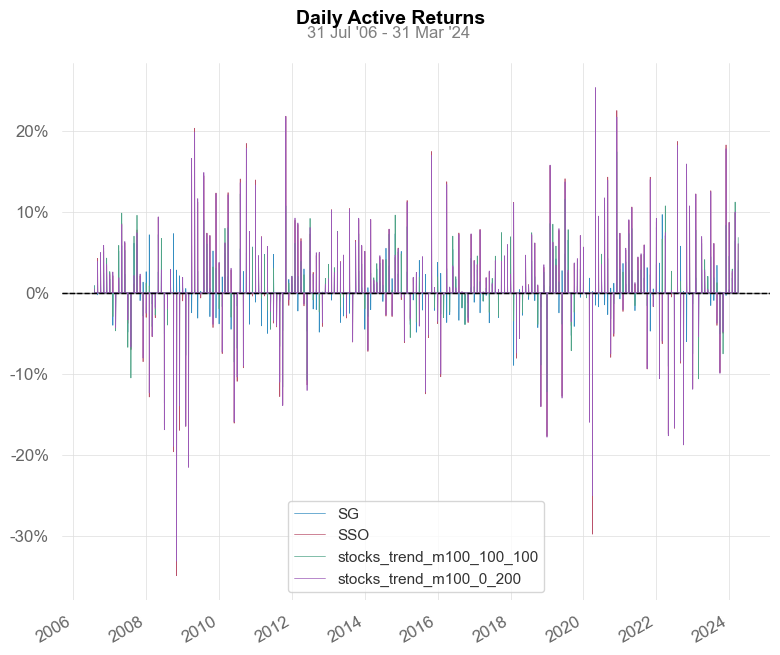

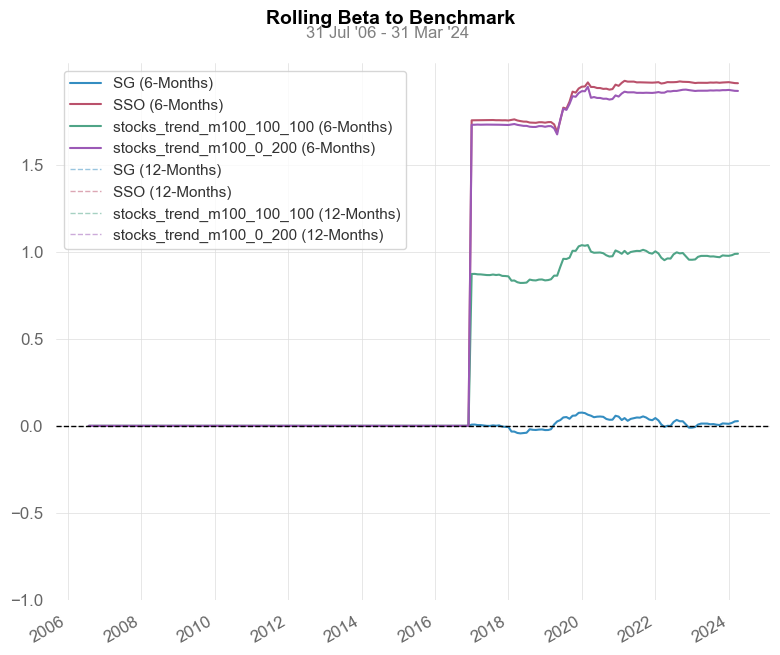

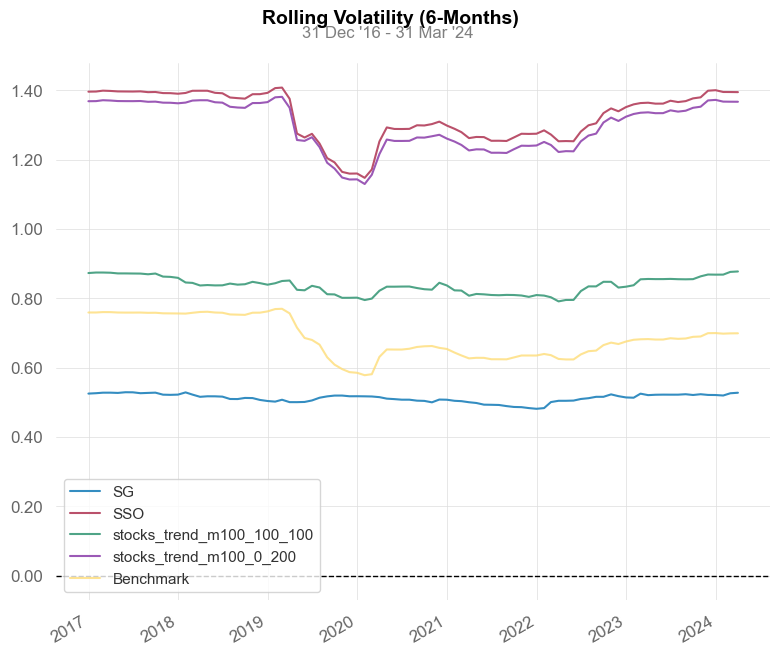

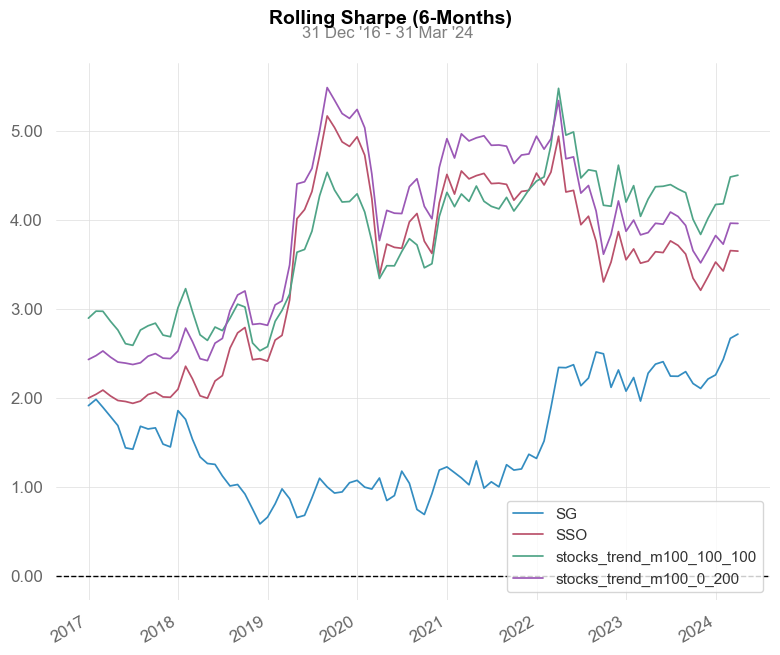

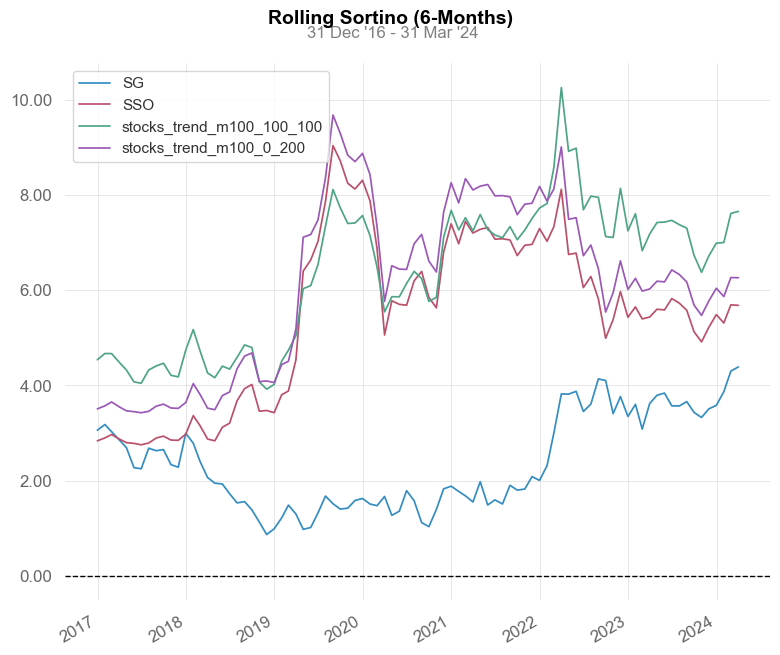

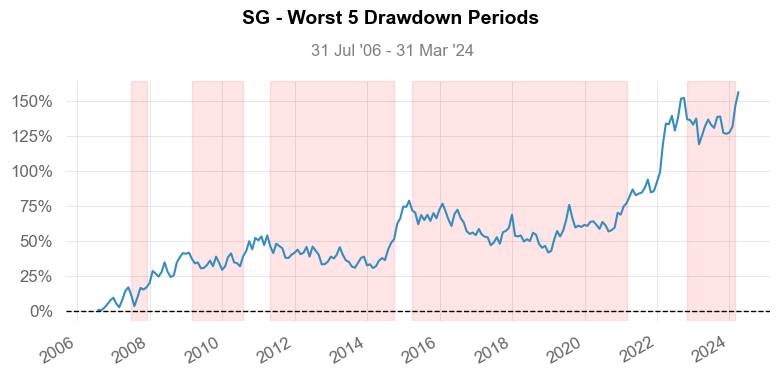

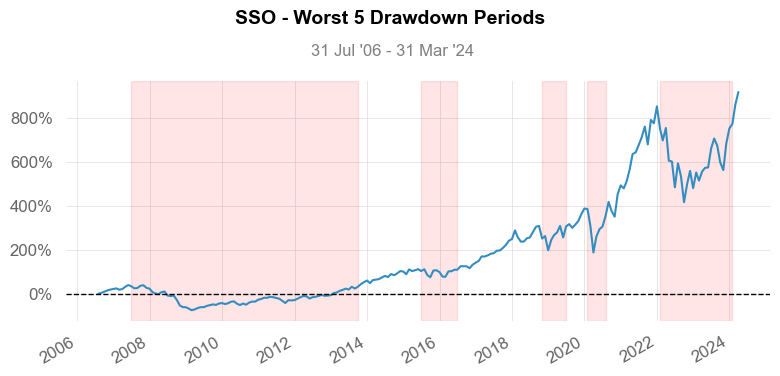

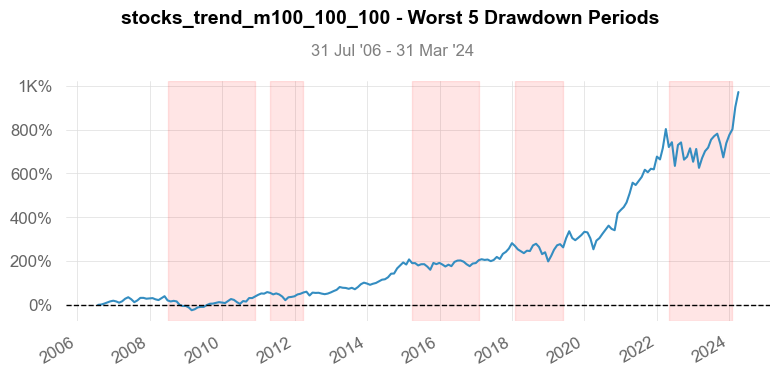

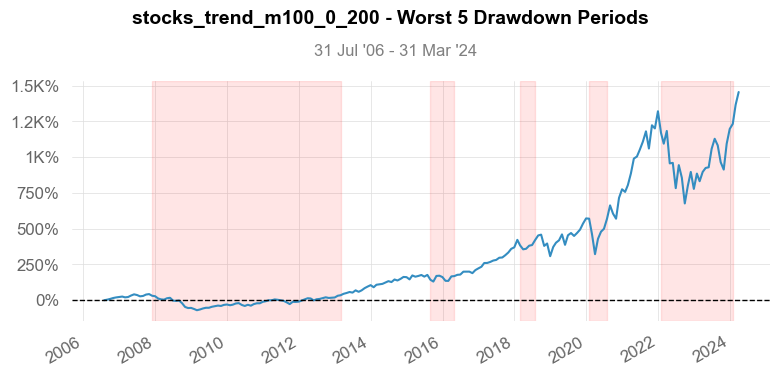

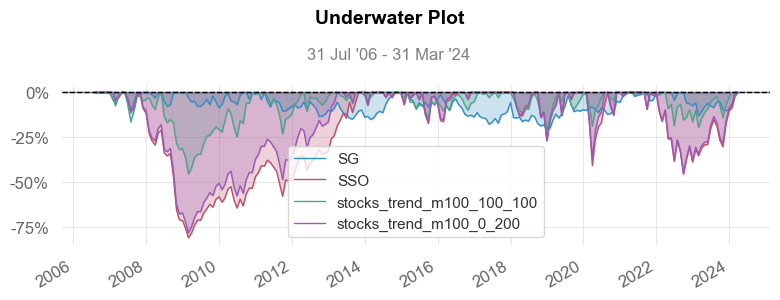

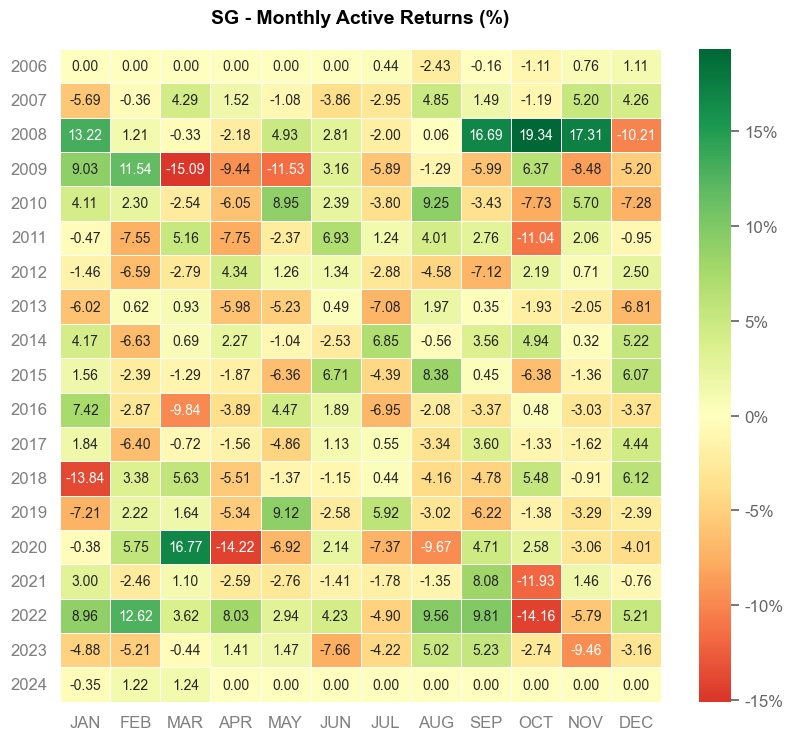

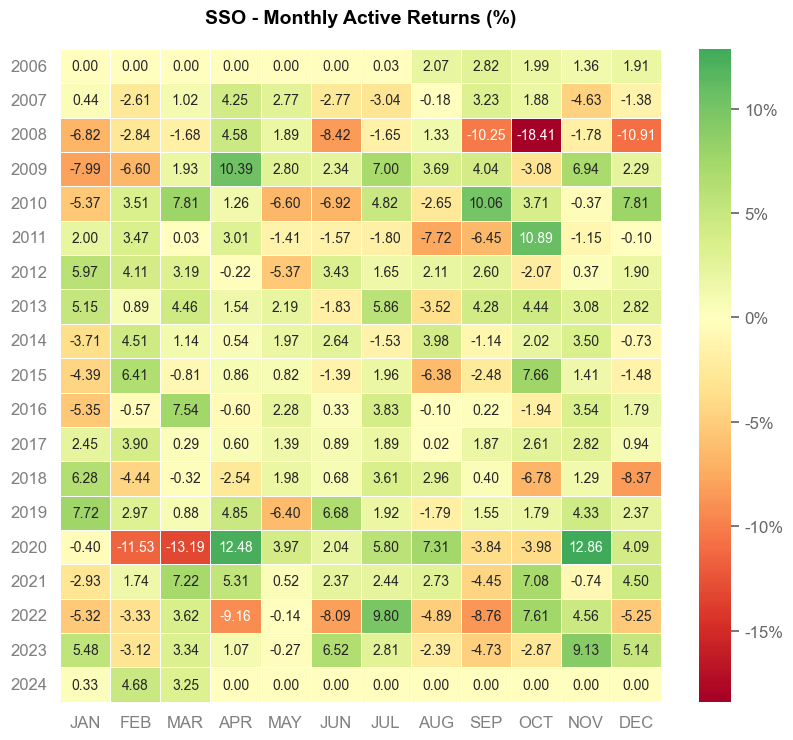

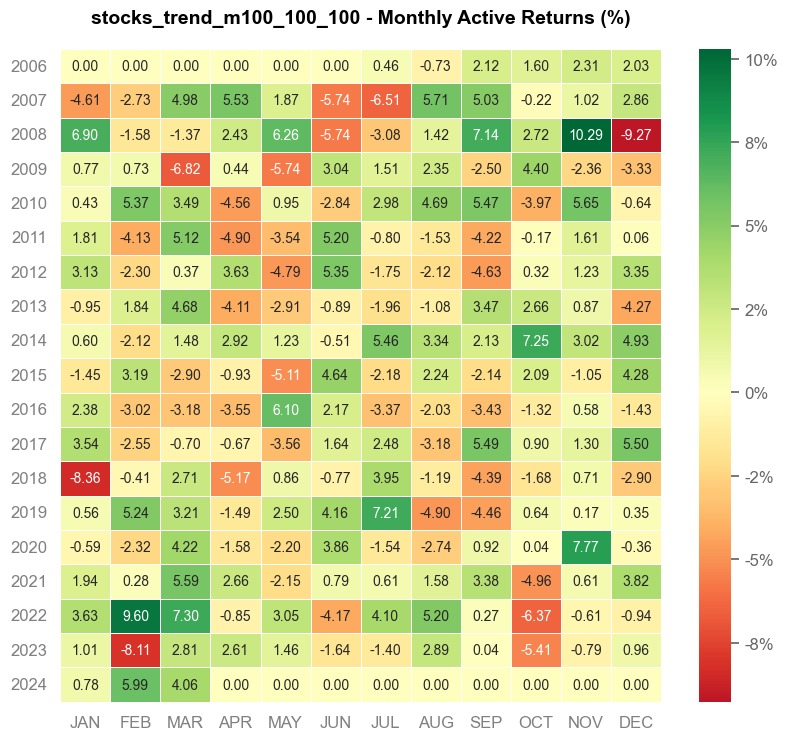

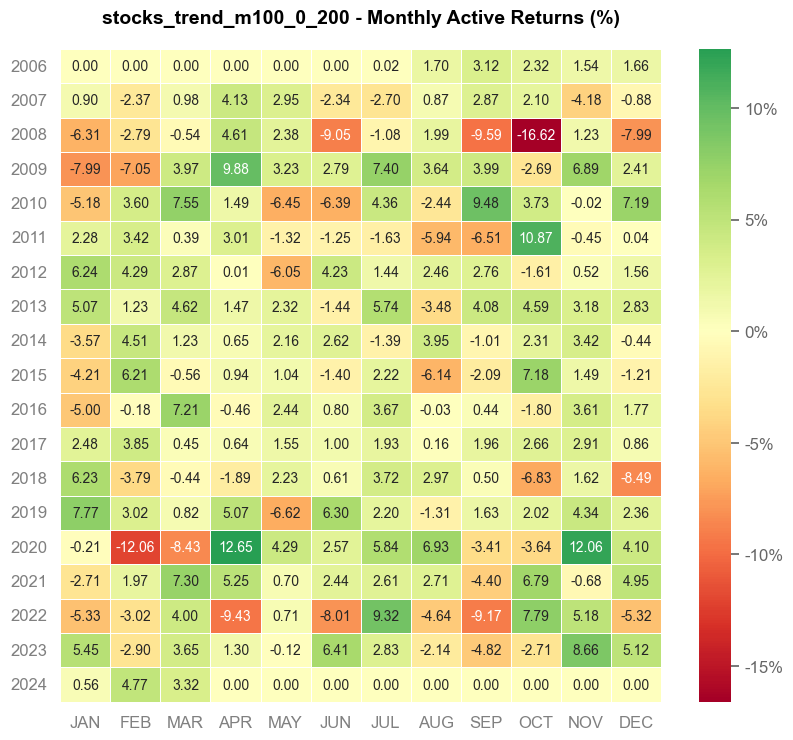

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1019: FutureWarning:

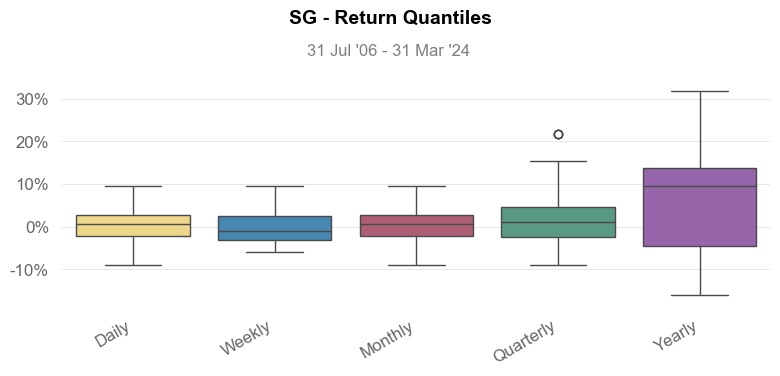

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1019: FutureWarning:

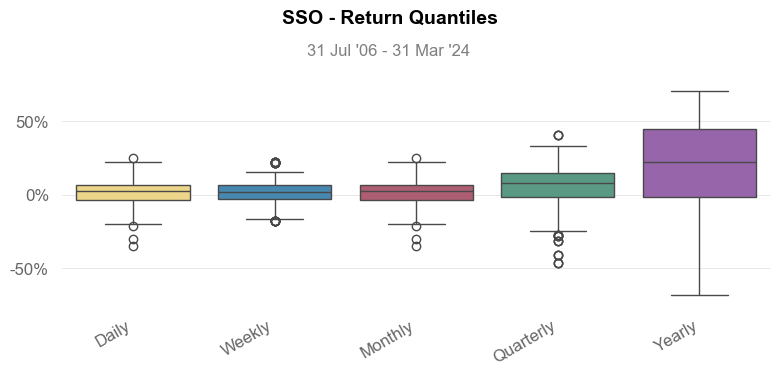

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1019: FutureWarning:

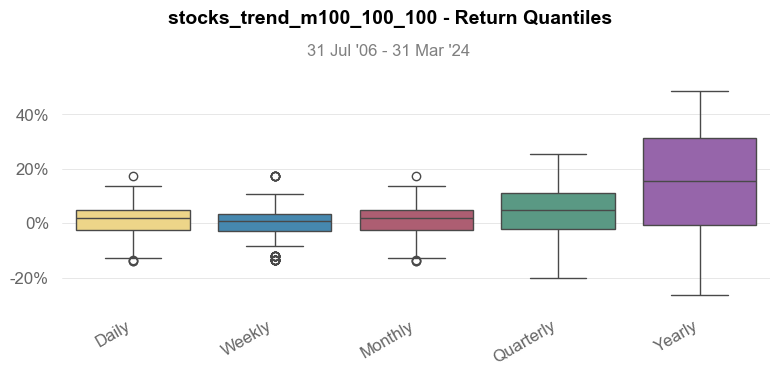

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1019: FutureWarning:

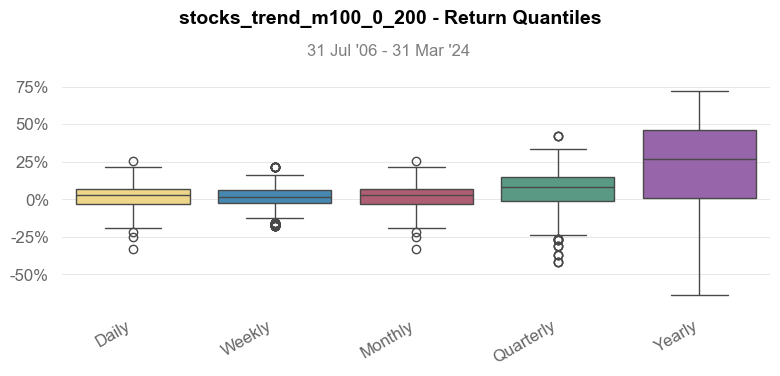

In [329]:
qs.reports.full(data1, benchmark="SPY")